In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation, Conv1D, MaxPooling1D, Masking, GaussianNoise
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('./data/processed_train.csv')
td = pd.read_csv('./data/processed_test.csv')

In [3]:
train_df.loc[train_df['RUL']>130,['RUL']]=130

In [4]:
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s20,s21,mode1,mode2,mode3,mode4,mode5,mode6,RUL,cycle_norm
0,1,1,0.833134,0.997625,1.0,0.060269,0.181576,0.311201,0.273095,0.146592,...,0.156036,0.159082,0.0,0.0,0.0,1.0,0.0,0.0,130,0.000000
1,1,2,0.999767,0.998575,1.0,0.000000,0.131847,0.296600,0.245535,0.000000,...,0.007888,0.014562,0.0,1.0,0.0,0.0,0.0,0.0,130,0.002653
2,1,3,0.595096,0.738480,0.0,0.238089,0.016332,0.035297,0.056997,0.293184,...,0.133745,0.151414,0.0,0.0,1.0,0.0,0.0,0.0,130,0.005305
3,1,4,0.999993,0.999525,1.0,0.000000,0.128269,0.298795,0.246979,0.000000,...,0.014060,0.026144,0.0,1.0,0.0,0.0,0.0,0.0,130,0.007958
4,1,5,0.595137,0.736698,0.0,0.238089,0.014130,0.037871,0.058152,0.293184,...,0.135460,0.143240,0.0,0.0,1.0,0.0,0.0,0.0,130,0.010610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,0.476188,0.831354,1.0,0.626985,0.672172,0.682297,0.591489,0.507937,...,0.486283,0.483993,0.0,0.0,0.0,0.0,1.0,0.0,4,0.824934
53755,260,313,0.238102,0.298100,1.0,0.597937,0.644830,0.733008,0.722934,0.617180,...,0.614540,0.622022,1.0,0.0,0.0,0.0,0.0,0.0,3,0.827586
53756,260,314,0.595222,0.736342,0.0,0.238089,0.017892,0.088067,0.082198,0.293184,...,0.137517,0.144474,0.0,0.0,1.0,0.0,0.0,0.0,2,0.830239
53757,260,315,0.595203,0.738717,0.0,0.238089,0.021195,0.079155,0.102368,0.293184,...,0.132716,0.134383,0.0,0.0,1.0,0.0,0.0,0.0,1,0.832891


In [5]:
# add noice to it


In [6]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191

In [7]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3','cycle_norm','mode1','mode2','mode3','mode4','mode5','mode6']
# sequence_cols = ['setting1', 'setting2', 'setting3','cycle_norm']
sequence_cols.extend(sensor_cols)

In [8]:
sequence_length = 60

In [9]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(38159, 60, 31)

In [10]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [11]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)


In [12]:
import keras.backend as K

In [13]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [14]:
def scoring_error(y_true, y_pred):
    diff = y_pred - y_true
    diff_pos = diff[diff>=0]
    diff_neg = diff[diff<0]
    score = K.sum(K.exp(-1./13.*diff_neg)-1.)+K.sum(K.exp(1./10.*diff_pos)-1.)

    return score

In [ ]:
from keras import backend as K 
import tensorflow as tf 
num_cores = 4
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_cores, inter_op_parallelism_threads=num_cores,
                        allow_soft_placement=True, device_count={'CPU': 4})
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [15]:
# Build model with mask
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(Masking(mask_value=0., input_shape=(sequence_length, nb_features)))
# model.add(GaussianNoise(0.1))
model.add(LSTM(
         units=100,
         return_sequences=True,))
model.add(Dropout(0.3))
model.add(LSTM(
          units=50,
          return_sequences=False,))
model.add(Dropout(0.3))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])
# model.compile(loss=scoring_error, optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 60, 31)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 100)           52800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
____________________________________________________________

In [78]:
# fit the network
model_path='deeplstm.h5'
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Train on 36251 samples, validate on 1908 samples
Epoch 1/100
 - 102s - loss: 5348.5906 - mean_absolute_error: 61.0277 - r2_keras: -2.0363e+00 - val_loss: 5636.3691 - val_mean_absolute_error: 62.7875 - val_r2_keras: -6.3659e+00
Epoch 2/100
 - 102s - loss: 4304.6245 - mean_absolute_error: 53.9220 - r2_keras: -1.4471e+00 - val_loss: 4612.1413 - val_mean_absolute_error: 56.3211 - val_r2_keras: -5.0698e+00
Epoch 3/100
 - 102s - loss: 3483.7610 - mean_absolute_error: 48.3634 - r2_keras: -9.8172e-01 - val_loss: 3760.6168 - val_mean_absolute_error: 50.9408 - val_r2_keras: -3.9600e+00
Epoch 4/100
 - 100s - loss: 2829.0138 - mean_absolute_error: 43.8834 - r2_keras: -6.0510e-01 - val_loss: 3075.7571 - val_mean_absolute_error: 46.6088 - val_r2_keras: -3.0291e+00
Epoch 5/100
 - 98s - loss: 2352.8872 - mean_absolute_error: 40.7057 - r2_keras: -3.3552e-01 - val_loss: 2561.3871 - val_mean_absolute_error: 43.3492 - val_r2_keras: -2.2837e+00
Epoch 6/100
 - 98s - loss: 2055.7532 - mean_absolute_error: 38

In [79]:
from matplotlib import pyplot

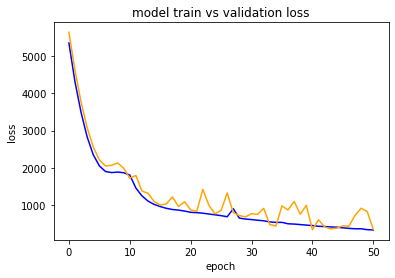

In [80]:
train = pd.DataFrame()
val = pd.DataFrame()
train[str(i)] = history.history['loss']
val[str(i)] = history.history['val_loss']
# plot train and validation loss across multiple runs
pyplot.plot(train, color='blue', label='train')
pyplot.plot(val, color='orange', label='validation')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.show()

In [23]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Loss: {}'.format(scores[0]))

40759/40759 [==============================] - 35s 868us/step
Loss: 265.07176238857187


In [81]:
test = []
for i in range(len(td.groupby('id'))):
    if len(td[td['id']==(i+1)]) >= sequence_length:
        test.append(np.asarray(td[td['id']==(i+1)][sequence_cols].values[-sequence_length:]).astype(np.float32).tolist())
    else:
        test.append(np.asarray(td[td['id']==(i+1)][sequence_cols].values[:]).astype(np.float32).tolist())

In [82]:
padded_inputs = keras.preprocessing.sequence.pad_sequences(test,dtype='float32',                                padding='post')

In [83]:
result = model.predict(padded_inputs,verbose=1)

259/259 [==============================] - 3s 11ms/step


In [84]:
submit = pd.read_excel('../results_submission.xls')
submit['RUL prediction']=result
submit.to_csv('lstm.csv')

In [85]:
ans = np.loadtxt('../RUL_FD002.txt')
ans.shape

(259,)

In [86]:
def score(user_ans):
    user_ans_arr = np.array(user_ans)
    score = 0
    diff = user_ans_arr - ans
    diff_pos = diff[diff>=0]
    diff_neg = diff[diff<0]
    score = np.sum((np.exp(-1./13.*diff_neg)-1))+np.sum((np.exp(1./10.*diff_pos)-1))
    return score

In [87]:
re = pd.read_csv('lstm.csv')
pred_rul=re['RUL prediction']

In [88]:
score(pred_rul)

14661.961728659346